<a href="https://colab.research.google.com/github/FelicianoRobles/FisicaComputacional1/blob/master/Evaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1

## Se construye un dataframe de columnas "Fecha" (de tipo datetime) y "value" (de tipo float), y en la columna value se sutituye el numero "-999.99" por "NaN".

In [271]:
# Bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Quitar alertas
%matplotlib inline

url = 'https://raw.githubusercontent.com/FelicianoRobles/FisicaComputacional1/master/Evaluacion1/Antartica_co2_spo_DailyData.txt' # URL de inf raw  
my_cols = ['site_code', 'year','month','day','hour','minute','second','time_decimal','value','value_std_dev','nvalue','latitude','longitude','altitude','elevation','intake_height','qcflag'] # Nombre a columnas
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=151, skipfooter=1, engine='python') # Leer

df_w0 = df_dist.copy() # Se hace una copia del dataframe
df_w1 = pd.DataFrame(df_w0,columns=['year','month','day']) # Se utilizan los datos de las 3 columnas de la copia del dataframe 
df_w1['Fecha'] = pd.to_datetime(df_w1) # Se conviernte en fecha

df_w2 = pd.DataFrame(df_w1,columns=['Fecha']) # Se utiliza otro dataframe
df_w2['value'] = df_w0['value'] # Se le agrega la columna de value

str_Nulo = -999.99 # Valor a reemplazar
df_w2 = df_w2.replace(to_replace=str_Nulo, value='NaN', regex=True) # Reemplazar el valor mencionado por NaN
 
print(df_w2.head()) # Cabeza
print(df_w2.tail()) # Cola
df_w2.dtypes # Tipos

       Fecha value
0 1975-01-01   NaN
1 1975-01-02   NaN
2 1975-01-03   NaN
3 1975-01-04   NaN
4 1975-01-05   NaN
           Fecha   value
16430 2019-12-26  409.12
16431 2019-12-27  409.06
16432 2019-12-28     409
16433 2019-12-29   408.7
16434 2019-12-30  408.41


Fecha    datetime64[ns]
value            object
dtype: object

## Se limita el dataframe a el periodo de 1980 hasta fin de 2019, se convierte el dataframe a una serie de tiempo usando "Fecha" como indice

In [272]:
df_w2 = df_w2.set_index('Fecha') # Indice 'Fecha 'del DataFrame

start, end = '1980-01', '2019-12' # Periodo pedido

df_w3 = df_w2.loc[start:end].copy() # Recorte de datos
ts_test = df_w3['value'] # Con lo que se trabajara
ts_test = ts_test.astype(float) # Se convierten los datos a float, ya que no estaban en float

ts_test.ffill(axis = 0, inplace=True) # Se llenan los espacios vacios

print(ts_test.head()) # Cabeza
print(ts_test.tail()) # Cola

Fecha
1980-01-01    336.30
1980-01-02    336.28
1980-01-03    336.21
1980-01-04    336.19
1980-01-05    336.20
Name: value, dtype: float64
Fecha
2019-12-26    409.12
2019-12-27    409.06
2019-12-28    409.00
2019-12-29    408.70
2019-12-30    408.41
Name: value, dtype: float64


# Parte 2

## Función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller

In [168]:
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Se prueba la estacionaridad de la serie de tiempo

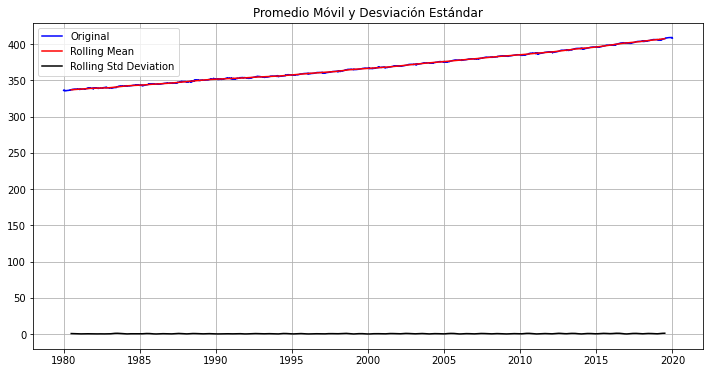

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     0.967299
p-value                            0.993909
#Lags Used                        42.000000
Number of Observations Used    14566.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [221]:
test_stationarity(ts_test)

p > 0.05

## Como no es estacionaria se cambia de escala a log(CO2) y se grafica

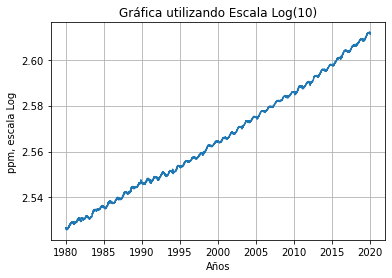

In [274]:
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años')
plt.ylabel('ppm, escala Log')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

## Descomposición estacional y graficas. 
Se hace una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. 

Se prodeuce las gráficas de las series que la componen. 

Y comentar la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).  

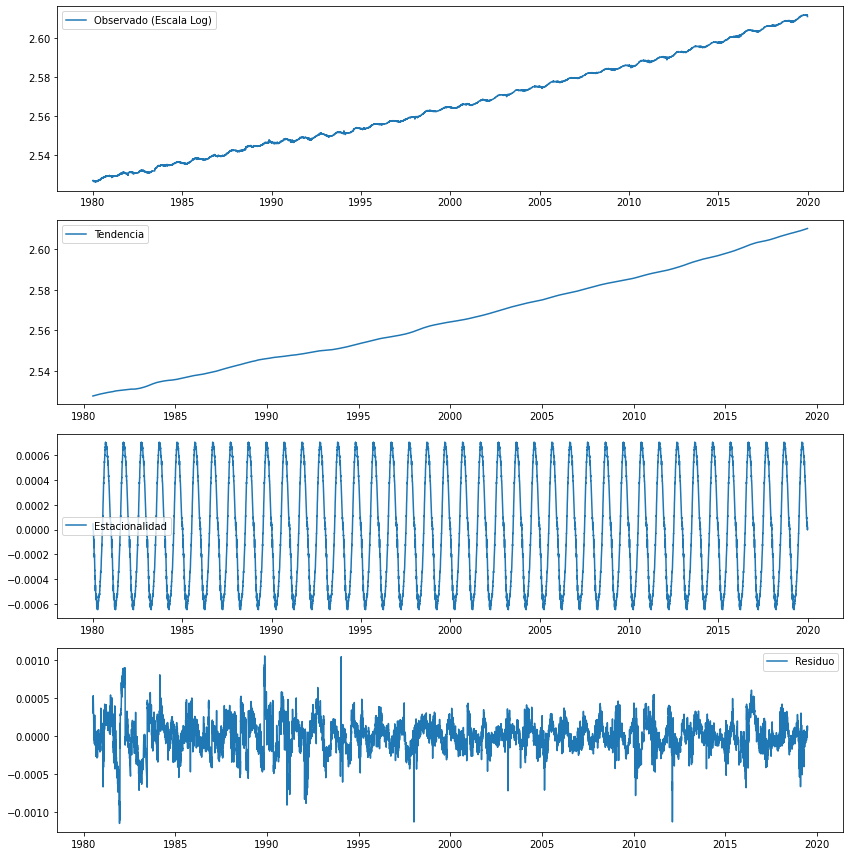

In [275]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

trend = decomposition.trend # Tendencia
seasonal = decomposition.seasonal # Estacionalidad
residue = decomposition.resid # Residuo


plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)') # Se grafican los datos obesrvados
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia') # Se grafica la tendencia
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad') # Se grafica la estacionalidad
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo') # Se grafica el residuo
plt.legend(loc='best')

plt.tight_layout(); # Gráficas cercanas

La serie de tendencia: El aumento de CO2 tiene un comportamiento de crecimiento casi perfectamente lineal al ojo.

La estacionalidad: Se ven claros patrones en estos datos

El residuo: se ve como varia con respecto a un valor central.

## Se prueba la estacionaridad de la serie residuo

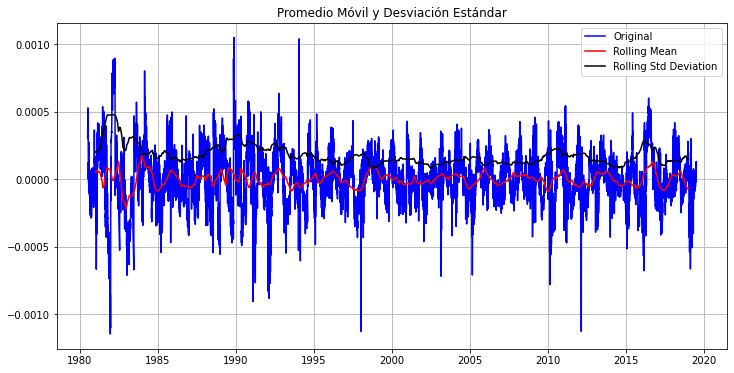

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135671e+01
p-value                        9.694298e-21
#Lags Used                     2.800000e+01
Number of Observations Used    1.421600e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [276]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue # Residuo
ts_test_log_decompose.dropna(inplace=True) # Se quitan los datos sin valor
test_stationarity(ts_test_log_decompose) # Se prueba la estacinoaridad

## Promedio móvil.
Promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastado en una gráfica con la serie de Log CO2.

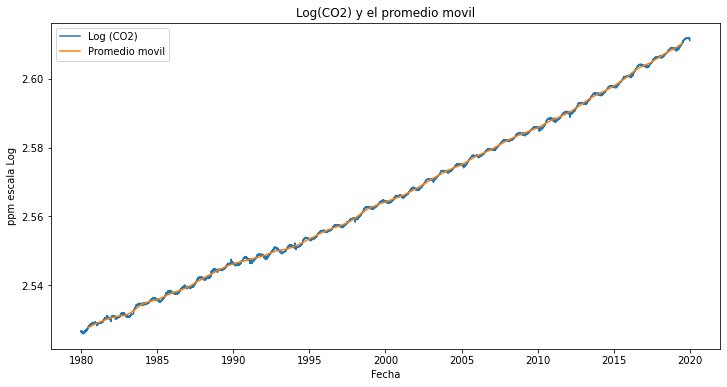

In [277]:
moving_avg = ts_test_log.rolling(365, center=True).mean() # Se calcula el promedio movil

plt.rcParams["figure.figsize"] = (12,6) # Tamaño de las gráficas

plt.plot(ts_test_log, label='Log (CO2)');
plt.plot(moving_avg, label='Promedio movil');
plt.xlabel('Fecha')
plt.ylabel('ppm escala Log')
plt.title('Log(CO2) y el promedio movil')
plt.legend(loc='best');

## Nuevo dataframe.
Se define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y se prueba después su estacionaridad.

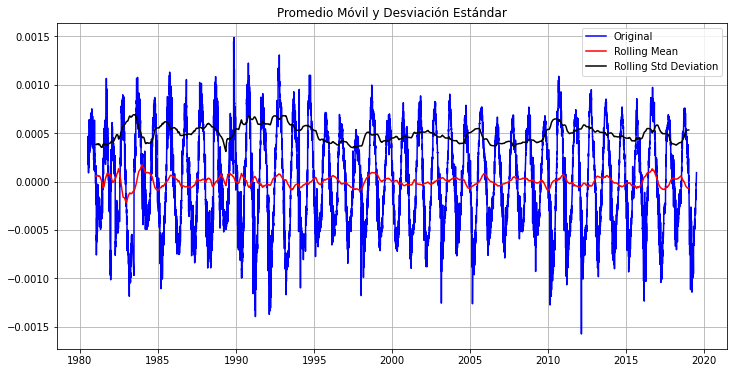

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.135404e+01
p-value                        9.834028e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [278]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg # Nuevo dataframe

ts_test_log_moving_ave_diff.dropna(inplace=True) # Se quitan datos sin valor
ts_test_log_moving_ave_diff.head() # Cabeza

test_stationarity(ts_test_log_moving_ave_diff) # Estacionaridad

## Serie estacionaria usando shift.
Se construye una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil. 

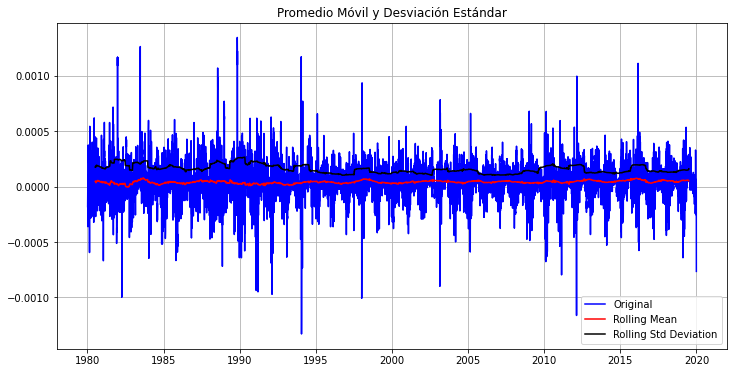

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.171116e+01
p-value                        1.487895e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [279]:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7) # Diferenciamos usando la función df.shift() y se crea una nueva serie
ts_test_log_diff.dropna(inplace=True) # Quitar datos sin valor
test_stationarity(ts_test_log_diff) # Estacionaridad

## Modelo ARIMA.
Se construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utilizando d=1 (ya que se ha derivado una vez)



### Se calculan los parametros p, q

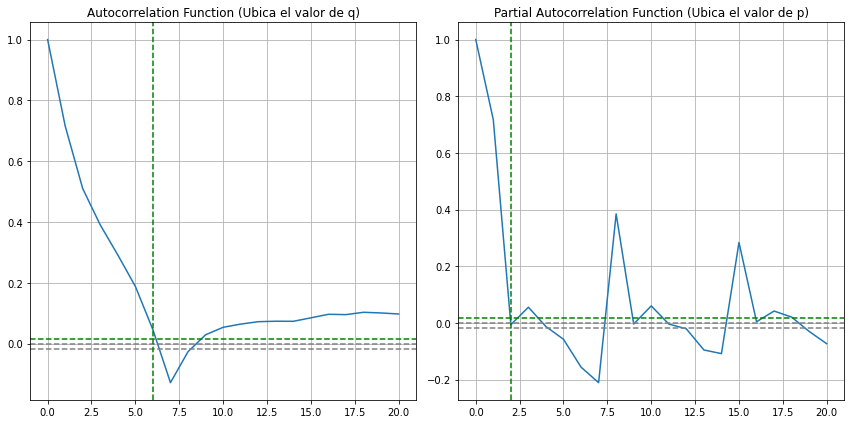

In [281]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green') # Línea horizontal de referencia
plt.axvline(x=6, linestyle='--', color='green') # Línea vertical de referencia
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green') # Línea horizontal de referencia
plt.axvline(x=2, linestyle='--', color='green') # Línea vertical de referencia
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout() # Graficas cerca

### Modelo AR (Auto-Regresion)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116090.653
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -232173.306
Time:                        22:54:57   BIC                        -232142.948
Sample:                    01-02-1980   HQIC                       -232163.220
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.785e-06   5.34e-07     10.835      0.000    4.74e-06    6.83e-06
ar.L1.D.value    -0.1516      0.008    -18.600      0.000      -0.168      -0.136
ar.L2.D.value    -0.1747      0.008    -

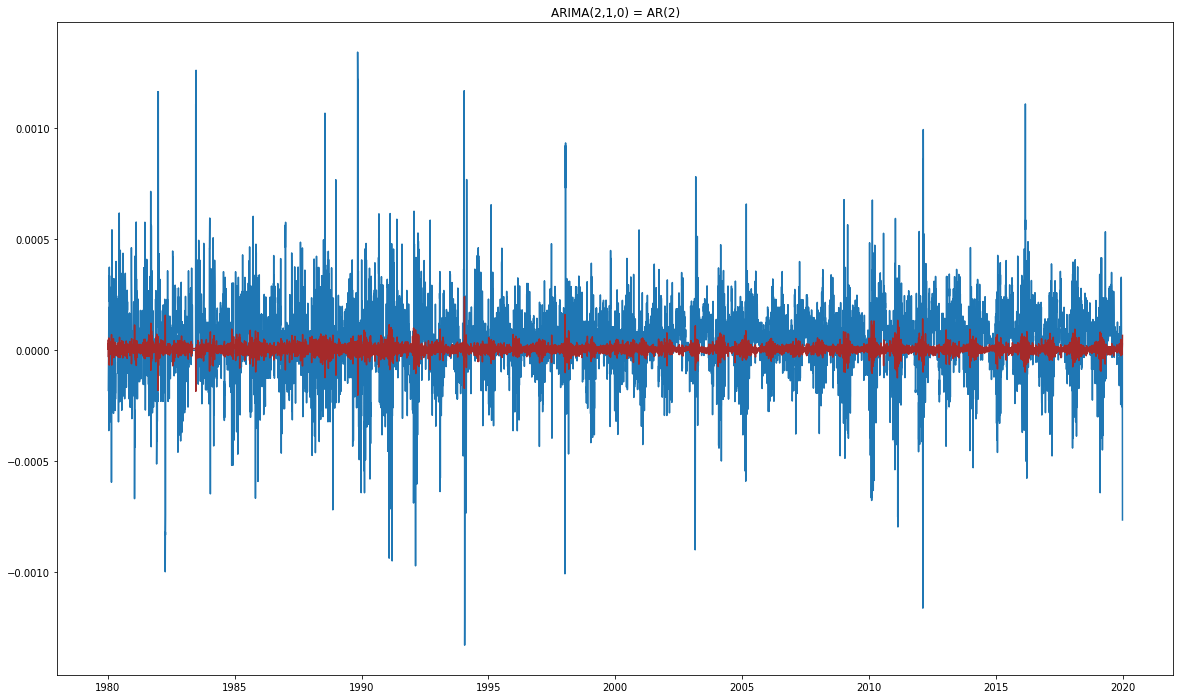

In [250]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

In [251]:
AR='AR: -232173.306'

### Modelo MA (Promedio Móvil)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(0, 1, 6)   Log Likelihood              116190.017
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -232364.033
Time:                        22:55:23   BIC                        -232303.319
Sample:                    01-02-1980   HQIC                       -232343.863
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.791e-06   4.13e-07     14.024      0.000    4.98e-06     6.6e-06
ma.L1.D.value    -0.2070      0.008    -25.120      0.000      -0.223      -0.191
ma.L2.D.value    -0.1796      0.009    -

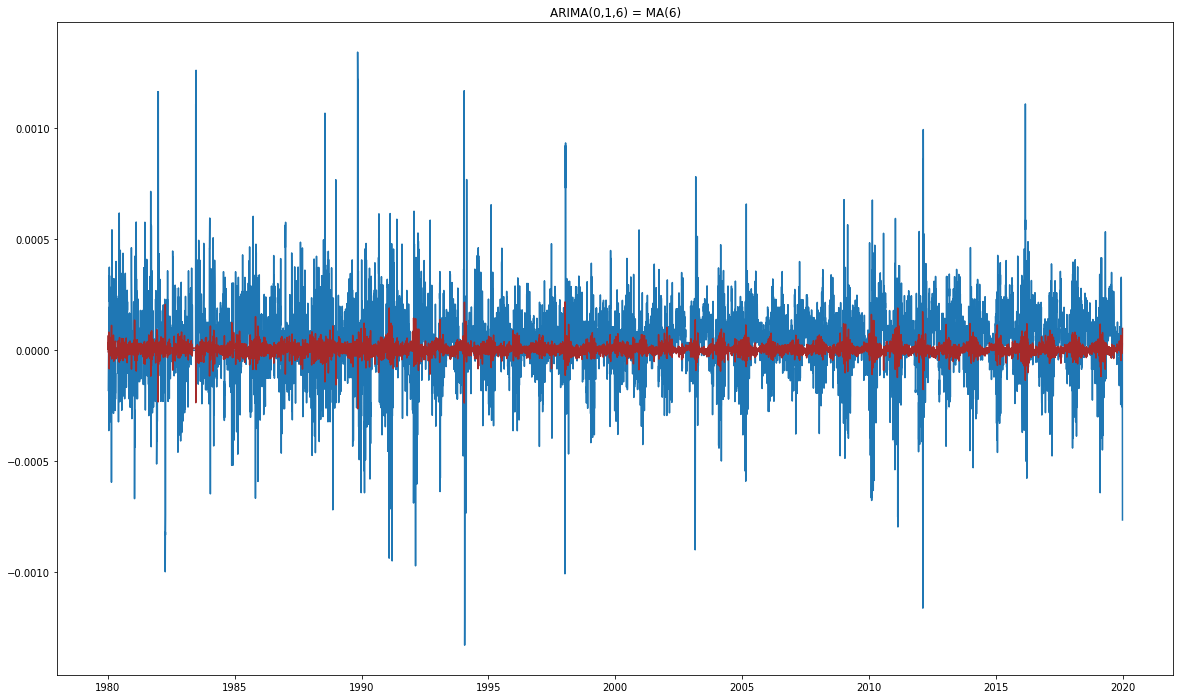

In [252]:
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

In [253]:
MA='MA: -232364.033'

### Modelo ARIMA (Auto-Regresion + Promedio Movil)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116198.516
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -232377.031
Time:                        22:56:22   BIC                        -232301.138
Sample:                    01-02-1980   HQIC                       -232351.818
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.794e-06   4.14e-07     14.001      0.000    4.98e-06    6.61e-06
ar.L1.D.value     0.3657        nan        nan        nan         nan         nan
ar.L2.D.value    -0.6900        nan     

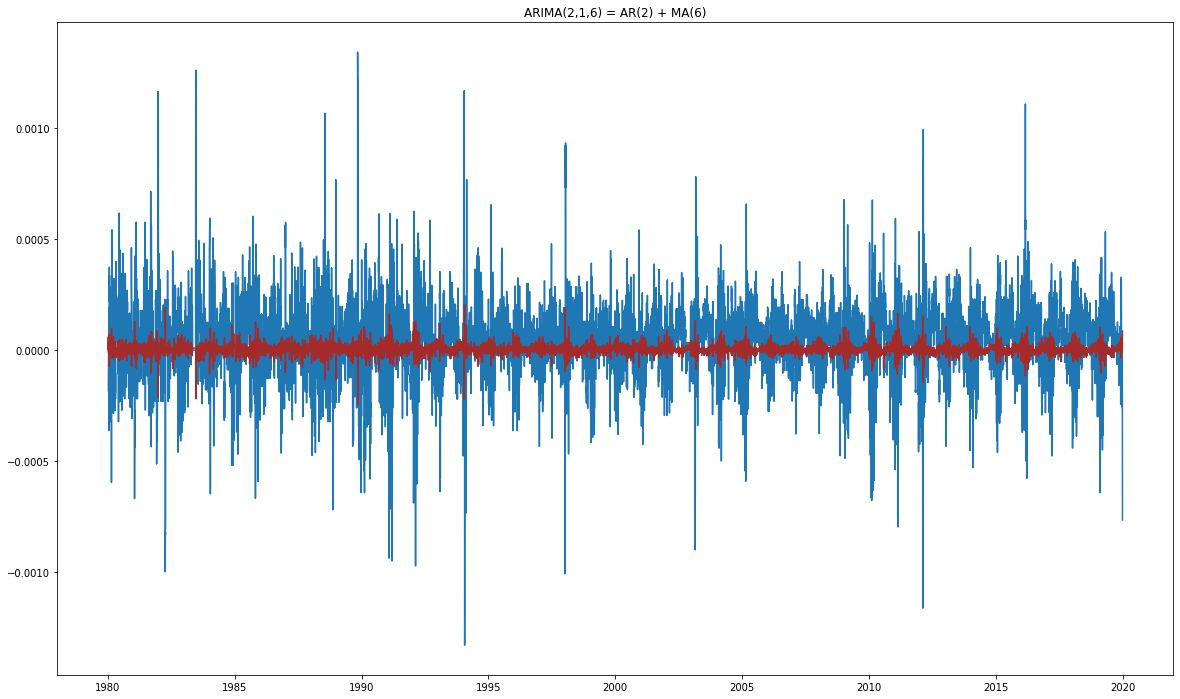

In [254]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [255]:
ARIMA='ARIMA: -232377.031'

### Se elige el modelo adecuado

In [256]:
print(AR)
print(MA)
print(ARIMA)

AR: -232173.306
MA: -232364.033
ARIMA: -232377.031


In [ ]:
print('ARIMA(2,1,6): AIC = -232377.031 <- Es el menor AIC')

Al tener el menor AIC, seleccionamos el modelo ARIMA(2,1,6)

## Contraste
Se contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA

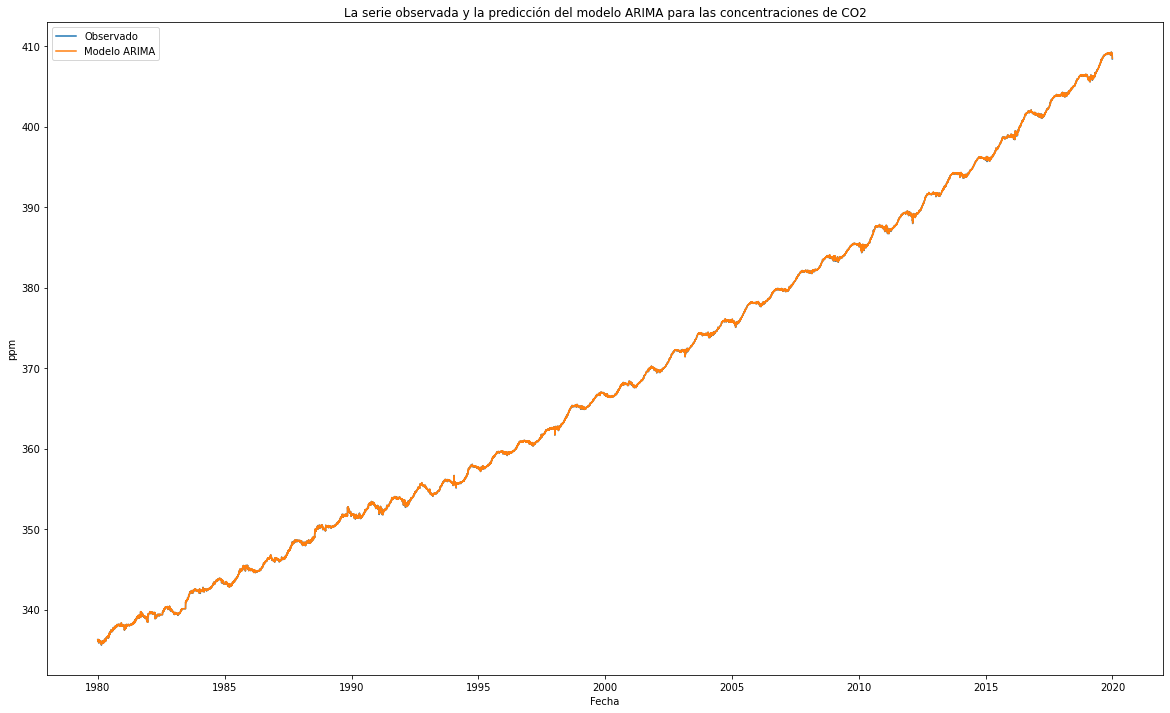

In [282]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True) # Se define la prediccion
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index) 
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff) # Se agrega la prediccion a la serie observada

predictions_ARIMA = 10**(predictions_ARIMA_log) # Regresamos a la escala original 

plt.rcParams["figure.figsize"] = (20,12)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('ppm')
plt.title('La serie observada y la predicción del modelo ARIMA para las concentraciones de CO2')
plt.legend(loc='best');

## Error RMSE

In [261]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('\033[1m','El error de la Raiz Cuadrada de la Media es:', '\033[0m', RMSE)

 El error de la Raiz Cuadrada de la Media es:  0.018819871773235814


## Contraste (ultimos 5 años)
Se contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

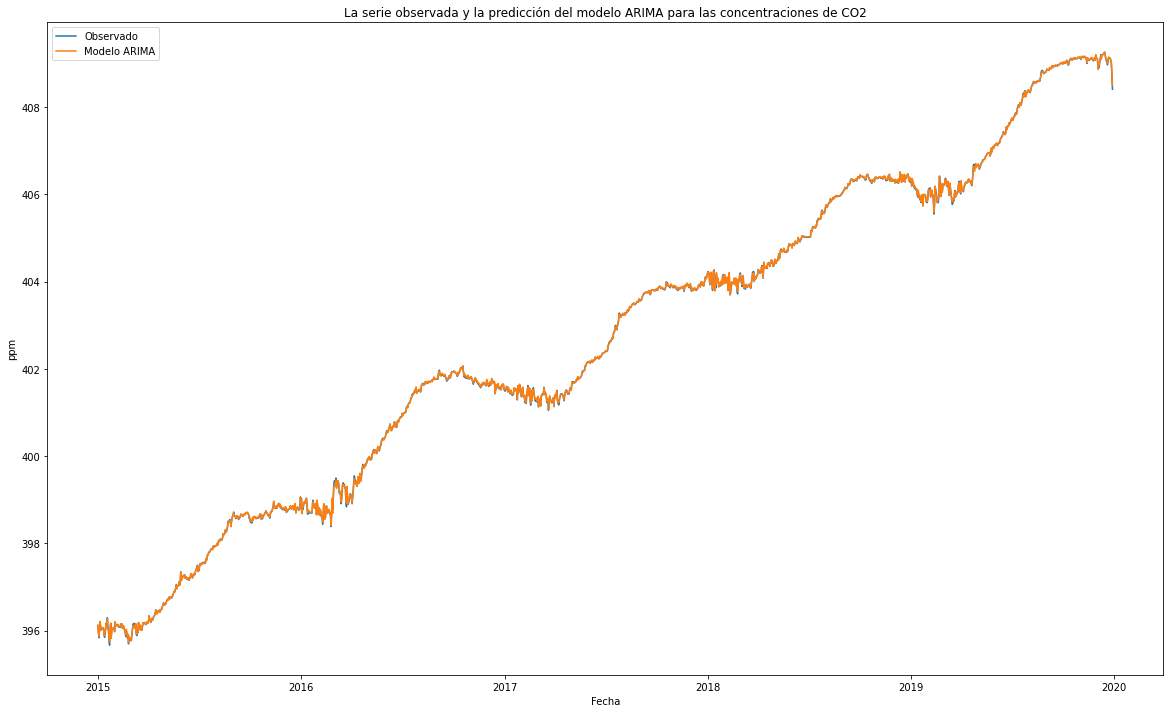

In [284]:
start, end = '2015-01', '2019-12' # Periodo de 5 años

ts_test_5 = ts_test.loc[start:end].copy()
predictions_ARIMA_5 = predictions_ARIMA.loc[start:end].copy()

plt.rcParams["figure.figsize"] = (20,12)

plt.plot(ts_test_5, label='Observado');
plt.plot(predictions_ARIMA_5, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('ppm')
plt.title('La serie observada y la predicción del modelo ARIMA para las concentraciones de CO2')
plt.legend(loc='best');